# Task 2 Modelling:  
(45 Minutes Max)

1) Build a model (or models) to predict the winner.  
2) Evaluate your model(s) performance and briefly detail any methods or logic you are using to do so.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# !pip install imblearn
from imblearn.over_sampling import RandomOverSampler

## Import processed data

In [3]:
data_path = "../data/processed/Horses.pickle"
df = pd.read_pickle(data_path)
df.shape

(36819, 78)

In [4]:
df.head()

,RaceID,HorseID,Cloth,Stall,WeightValue,JockeyID,TrainerID,OwnerID,LastRunDaysFlat,Age,...,Colour_ch,Colour_dkb,Colour_g,Colour_gr,Colour_gr/,Sex_c,Sex_f,Sex_g,Sex_h,Sex_m
0,989418,2963489,7,5.0,132,1398052.0,1198534,1289143.0,26.0,3.0,...,0,0,0,0,0,0,1,0,0,0
1,989418,2972665,13,6.0,132,1165412.0,1188128,1140080.0,NaN,3.0,...,0,0,0,0,0,0,1,0,0,0
2,989418,2972662,9,7.0,132,1239852.0,1199122,1448576.0,NaN,3.0,...,0,0,0,0,0,0,1,0,0,0
3,989418,2960365,1,12.0,132,1417524.0,1049637,1487690.0,33.0,3.0,...,0,0,0,0,0,0,1,0,0,0
4,989418,2968596,11,8.0,132,1354773.0,1140041,1403676.0,24.0,3.0,...,0,0,0,0,0,0,1,0,0,0


## Create X, y

In [5]:
# due to time constraints, going to omit ID columns;
id_cols = [col for col in df.columns if 'id' in col.lower()]

# and ones with nulls...
nulls = df.columns[(df.isnull().sum() > 0).values]
nulls = set(nulls).difference(id_cols)

In [6]:
y = df['Won']

In [7]:
y.value_counts()

0    33912
1     2907
Name: Won, dtype: int64

In [8]:
X = df.drop(columns= id_cols + list(nulls))

In [9]:
X.head()

,Cloth,WeightValue,RaceNumber,HorseCount,Course_Distance,Handicap,MeetingDate,Won,forecast_price_cleaned,starting_price_cleaned,...,Colour_ch,Colour_dkb,Colour_g,Colour_gr,Colour_gr/,Sex_c,Sex_f,Sex_g,Sex_h,Sex_m
0,7,132,1,13,1312,0.0,2017-05-02,0,16.00,12.000000,...,0,0,0,0,0,0,1,0,0,0
1,13,132,1,13,1312,0.0,2017-05-02,0,20.00,40.000000,...,0,0,0,0,0,0,1,0,0,0
2,9,132,1,13,1312,0.0,2017-05-02,0,10.00,20.699157,...,0,0,0,0,0,0,1,0,0,0
3,1,132,1,13,1312,0.0,2017-05-02,1,1.75,1.100000,...,0,0,0,0,0,0,1,0,0,0
4,11,132,1,13,1312,0.0,2017-05-02,0,8.00,20.699157,...,0,0,0,0,0,0,1,0,0,0


## Create Train & Validation Datasets  
Ordered by time

In [10]:
X = X.sort_values(by='MeetingDate')

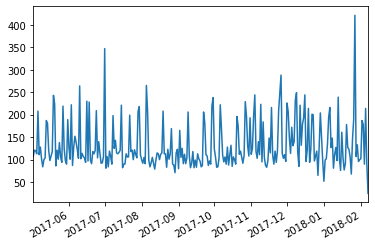

In [11]:
X['MeetingDate'].value_counts().plot()

Let's train on 2017 and validate against the first two months of 2018...

In [12]:
cond = df.MeetingDate.dt.year < 2018
trn_idx = np.where(cond)[0]
val_idx = np.where(~cond)[0]

X = X.drop(columns=['MeetingDate'])
print(len(trn_idx), len(val_idx))

X_trn, X_val, y_trn, y_val = X.iloc[trn_idx], X.iloc[val_idx], y.loc[trn_idx], y.loc[val_idx]

print(len(X_trn), len(X_val), len(y_trn), len(y_val))

31794 5025
31794 5025 31794 5025


*would usually create a test set to tune hyperparameters

## Baseline model

In [13]:
def accuracy(actuals, preds):
    return (preds == actuals).sum() / len(actuals)

In [14]:
# fitting default classifier to get a baseline accuracy...
rc = RandomForestClassifier()

rc.fit(X_trn, y_trn)

preds = rc.predict(X_val)
proba = rc.predict_proba(X_val)

In [15]:
accuracy(y_val, preds)

0.9209950248756219

^^^ Looks to good to be true! Let's print out the f1-score, precision & recall...

In [16]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4628
           1       0.00      0.00      0.00       397

    accuracy                           0.92      5025
   macro avg       0.46      0.50      0.48      5025
weighted avg       0.85      0.92      0.88      5025



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


^^^ model isn't predicting any winners!  Accuracy isn't a good metric for this imbalanced dataset, so will switch to f1-score - which captures precision and recall.

## Over-sampling winners  

Randomly oversample the minority class to see if the model better learns 'winners'

In [17]:
ros = RandomOverSampler(sampling_strategy='not majority', random_state=171)
X_trn_os, y_trn_os = ros.fit_resample(X_trn, y_trn)

In [18]:
y_trn_os.value_counts()

1    29284
0    29284
Name: Won, dtype: int64

In [19]:
# refit model...
rc.fit(X_trn_os, y_trn_os)
preds = rc.predict(X_val)
proba = rc.predict_proba(X_val)[:, 1]  # probability estimates for winning.
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4628
           1       0.00      0.00      0.00       397

    accuracy                           0.92      5025
   macro avg       0.46      0.50      0.48      5025
weighted avg       0.85      0.92      0.88      5025



Over-sampling hasn't helped!  Let's have a look at the probability distibution...

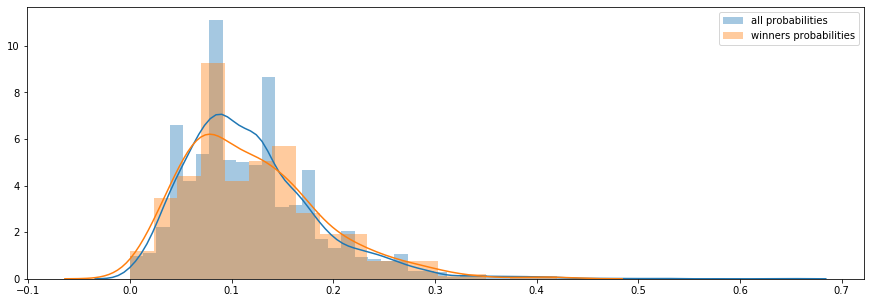

In [20]:
plt.figure(figsize=(15, 5))
sns.distplot(proba, hist=True, label='all probabilities')
sns.distplot(proba[y_val==1], hist=True, label='winners probabilities')
plt.legend()
plt.show()

This shows that the model is unable distinguish winners from losers.  The winners distribution is very very marginally nudged to the right.

# <font color= orange> Times up! </font> 

## Next Steps... 

1. I've assumed that the Forecast and Starting Price are both available and not leaking information - it would be good to have a data dictionary to confirm this.  
2. The model above is surprising; the EDA suggests that there are some predictive features - so it might be a good idea to see if 2017 and 2018 are similar i.e. is the training accuracy/ f1-score the same?  Has the data drifted year on year?  
3. I don't think the training data is constructed correctly at the moment - I would like to give more thought to this.  We have discrete events in the data (defined by RaceID) and I am not acknowledging this at the moment.  

**Once I have the data structured correctly, I would...**
* Generate some new features that consider the horses previous form and competitors in the race.
* Calculate feature importances or conduct Recursive Feature Elimination to retain the better predictors and reduce model complexity/ maintenance debt.  
* Hyper-parameter tune using a test set and make sure that the model generalises well to new data.  
* Consider other algorithms once I have a working baseline model.

**Further to point 3 above...**  
* I wondered if I could apply softmax to the probabilities and calculate the relative probability of a horse winning within the race (as opposed to the whole dataset)? Otherwise I might predict several winners in one race!  
* With that in mind, could I create a loss function that understands there's only one winner and therefore all others must be losers...


## Feature importances

## Softmax

In [110]:
def softmax(x):
    """Compute softmax values for each sets of scores in x.
    """
    return np.exp(x) / np.sum(np.exp(x), axis=0)